XGBoost Time series  [here](https://machinelearningmastery.com/xgboost-for-time-series-forecasting/)  
 
Chunks of data [here](https://machinelearningmastery.com/how-to-develop-machine-learning-models-for-multivariate-multi-step-air-pollution-time-series-forecasting/)

Multistep LSTM [here](https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/)  

Feature Scaling time series dataset pending

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import os
import utility

EXPERIEMENT_SEED = 42
np.random.seed(EXPERIEMENT_SEED)

### Importing Dataset

In [2]:
weather_df = utility.get_processed_dataset()
weather_df.head(4)

,pyranometer,pyroheliometer,azimuth_angle_deg,tower_dry_bulb_temp_deg,tower_wet_bulb_temp_deg,tower_dew_point_deg,tower_rh_pct,peak_wind_speed_mps,avg_wind_direction_deg,station_pressure_mbar,precipitation_mm,snow_depth_cm,moisture,albedometer,datetime_cpy,total_cloud_coverage_pct
datetime,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,-0.962276,0.000000,356.85640,7.216,0.988,-7.312,32.33,9.95,271.3,806.779,0.0,0.219,0.0,0.0,2020-01-01 00:00:00,-1
2020-01-01 00:01:00,-0.937921,0.000000,357.65505,7.251,1.040,-7.260,32.40,8.20,272.9,806.840,0.0,0.206,0.0,0.0,2020-01-01 00:01:00,-1
2020-01-01 00:02:00,-0.944395,0.000000,358.45438,7.256,1.093,-7.207,32.54,6.70,288.8,806.876,0.0,0.148,0.0,0.0,2020-01-01 00:02:00,-1
2020-01-01 00:03:00,-0.951350,-0.029673,359.25416,7.254,1.060,-7.440,31.89,7.70,294.0,806.823,0.0,0.235,0.0,0.0,2020-01-01 00:03:00,-1


### Sampling One Day Data example

In [3]:
weather_df_1day = weather_df.loc['2020-01-01 00:00:00' : '2020-01-01 23:59:00'] \
                                .loc[weather_df['total_cloud_coverage_pct'] > -1]
weather_df_1day.head(4)

,pyranometer,pyroheliometer,azimuth_angle_deg,tower_dry_bulb_temp_deg,tower_wet_bulb_temp_deg,tower_dew_point_deg,tower_rh_pct,peak_wind_speed_mps,avg_wind_direction_deg,station_pressure_mbar,precipitation_mm,snow_depth_cm,moisture,albedometer,datetime_cpy,total_cloud_coverage_pct
datetime,,,,,,,,,,,,,,,,
2020-01-01 07:47:00,14.4935,0.079127,123.84491,6.933,1.403,-5.597,38.24,0.7,210.3,802.042,0.0,0.032,0.0,0.1951,2020-01-01 07:47:00,6
2020-01-01 07:48:00,16.5178,-0.034618,124.01096,6.793,1.294,-5.606,38.58,0.7,232.2,801.948,0.0,0.029,0.0,0.1867,2020-01-01 07:48:00,8
2020-01-01 07:49:00,18.6171,-0.153309,124.17734,6.674,1.260,-5.540,39.12,1.7,263.9,801.940,0.0,0.173,0.0,0.1783,2020-01-01 07:49:00,10
2020-01-01 07:50:00,20.5986,-0.143419,124.34405,6.646,1.306,-5.494,39.35,2.2,277.5,801.927,0.0,0.144,0.0,0.1758,2020-01-01 07:50:00,13


In [4]:
training_labels = utility.series_to_supervised(list(weather_df_1day['total_cloud_coverage_pct']), n_out=10)
training_labels.shape

(509, 11)

### Tentatively Selecting K best features per output label
Tentatively selecting K best features per output $t+n^{th}$ where n is future values after  minutes =  {10, 20, 30} to construct and train base architecture quickly

In [5]:
# pearson's correlation feature selection for numeric input and numeric output
from sklearn.datasets import make_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

# define feature selection
fs = SelectKBest(score_func=f_regression, k=6)

# apply feature selection
fs.fit_transform(weather_df.iloc[:, :-2].values, weather_df.iloc[:, -1].values)
print("best Feature Indices: ", fs.get_support(indices=True))

best_feature_cols = weather_df.columns[fs.get_support(indices=True)]
print("Best Feature Columns: ", best_feature_cols)

best Feature Indices:  [ 0  3  4  5  8 13]
Best Feature Columns:  Index(['pyranometer', 'tower_dry_bulb_temp_deg', 'tower_wet_bulb_temp_deg',
       'tower_dew_point_deg', 'avg_wind_direction_deg', 'albedometer'],
      dtype='object')


In [6]:
weather_df = pd.concat([weather_df[best_feature_cols], weather_df[['datetime_cpy', 'total_cloud_coverage_pct']]], axis=1)
weather_df.head(4)

,pyranometer,tower_dry_bulb_temp_deg,tower_wet_bulb_temp_deg,tower_dew_point_deg,avg_wind_direction_deg,albedometer,datetime_cpy,total_cloud_coverage_pct
datetime,,,,,,,,
2020-01-01 00:00:00,-0.962276,7.216,0.988,-7.312,271.3,0.0,2020-01-01 00:00:00,-1
2020-01-01 00:01:00,-0.937921,7.251,1.040,-7.260,272.9,0.0,2020-01-01 00:01:00,-1
2020-01-01 00:02:00,-0.944395,7.256,1.093,-7.207,288.8,0.0,2020-01-01 00:02:00,-1
2020-01-01 00:03:00,-0.951350,7.254,1.060,-7.440,294.0,0.0,2020-01-01 00:03:00,-1


### Sample 2 months to speed up model design

In [7]:
weather_df_jan_aug = pd.concat([weather_df[weather_df.datetime_cpy.dt.month == 1], weather_df[weather_df.datetime_cpy.dt.month == 8]], axis=0)
weather_df_jan_aug.head(4)

,pyranometer,tower_dry_bulb_temp_deg,tower_wet_bulb_temp_deg,tower_dew_point_deg,avg_wind_direction_deg,albedometer,datetime_cpy,total_cloud_coverage_pct
datetime,,,,,,,,
2020-01-01 00:00:00,-0.962276,7.216,0.988,-7.312,271.3,0.0,2020-01-01 00:00:00,-1
2020-01-01 00:01:00,-0.937921,7.251,1.040,-7.260,272.9,0.0,2020-01-01 00:01:00,-1
2020-01-01 00:02:00,-0.944395,7.256,1.093,-7.207,288.8,0.0,2020-01-01 00:02:00,-1
2020-01-01 00:03:00,-0.951350,7.254,1.060,-7.440,294.0,0.0,2020-01-01 00:03:00,-1


#### Removing datetime_cpy column since it is of no use onwards

In [8]:
weather_df_jan_aug.drop(columns=['datetime_cpy'], inplace=True)

#### Removing non recorded cloud coverages

In [9]:
weather_df_jan_aug = weather_df_jan_aug[weather_df_jan_aug['total_cloud_coverage_pct'] > -1]
weather_df_jan_aug.head(4)

,pyranometer,tower_dry_bulb_temp_deg,tower_wet_bulb_temp_deg,tower_dew_point_deg,avg_wind_direction_deg,albedometer,total_cloud_coverage_pct
datetime,,,,,,,
2020-01-01 07:47:00,14.4935,6.933,1.403,-5.597,210.3,0.1951,6
2020-01-01 07:48:00,16.5178,6.793,1.294,-5.606,232.2,0.1867,8
2020-01-01 07:49:00,18.6171,6.674,1.260,-5.540,263.9,0.1783,10
2020-01-01 07:50:00,20.5986,6.646,1.306,-5.494,277.5,0.1758,13


In [10]:
#Keep indexes aside
indexes_jan_aug = weather_df_jan_aug.index

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

weather_df_jan_aug_transformed = sc.fit_transform(weather_df_jan_aug[best_feature_cols])

#Converting back to dataframe
weather_df_jan_aug_transformed = pd.DataFrame(weather_df_jan_aug_transformed, index=indexes_jan_aug, columns=best_feature_cols)
weather_df_jan_aug = pd.concat([weather_df_jan_aug_transformed, weather_df_jan_aug['total_cloud_coverage_pct']], axis=1)
weather_df_jan_aug.head(4)

,pyranometer,tower_dry_bulb_temp_deg,tower_wet_bulb_temp_deg,tower_dew_point_deg,avg_wind_direction_deg,albedometer,total_cloud_coverage_pct
datetime,,,,,,,
2020-01-01 07:47:00,-1.335105,-0.970654,-0.873971,-0.450402,0.710774,-0.356840,6
2020-01-01 07:48:00,-1.327813,-0.982774,-0.888595,-0.451458,0.927943,-0.522128,8
2020-01-01 07:49:00,-1.320251,-0.993076,-0.893156,-0.443713,1.242291,-0.687416,10
2020-01-01 07:50:00,-1.313113,-0.995500,-0.886985,-0.438315,1.377154,-0.736608,13


#### Allocate day wise chunks

In [11]:
df_chunks_per_day = {}

month_day_pairs = utility.get_month_day_pairing(weather_df_jan_aug)

min_uptime_duration = np.inf;
max_uptime_duration = -np.inf;

for month, day in month_day_pairs:
    daily_chunk = weather_df_jan_aug.loc[((weather_df_jan_aug.index.month == month) \
                                                             &( weather_df_jan_aug.index.day == day)), :].values
    
    #TODO: Later Segment active minutes such that only 60 mins spaced time frames are present
    total_daily_active_minutes = np.shape(daily_chunk)[0]
    #Segmenting for max 8 hours per day
    max_daily_minutes = 8 * 60
    
    #TODO: Later Segment active minutes such that only 60 mins spaced time frames are present
    #total_daily_active_minutes = (total_daily_active_minutes // 60) * 60
    #Segmenting for max 8 hours per day
    df_chunks_per_day[(month,day)] = daily_chunk[:max_daily_minutes,:]
    
    if(total_daily_active_minutes < min_uptime_duration):
        min_uptime_duration = total_daily_active_minutes
        
    if(total_daily_active_minutes > max_uptime_duration):
        max_uptime_duration = total_daily_active_minutes
    
print("Shape of a sample day record: {} \n".format(np.shape(df_chunks_per_day[(1,21)])))
print("Overall Minimum Active Duration in hours: %d" % (min_uptime_duration // 60))
print("Overall Maximum Active Duration in hours: %d" % (max_uptime_duration // 60))

Shape of a sample day record: (480, 7) 

Overall Minimum Active Duration in hours: 8
Overall Maximum Active Duration in hours: 13


#### Randomly shuffling days

In [12]:
df_chunks_per_day_arr = list(df_chunks_per_day.items()) 
np.random.shuffle(df_chunks_per_day_arr)
df_chunks_per_day = dict(df_chunks_per_day_arr)

In [13]:
df_chunks_per_day[(8,20)]

array([[-1.31108016e+00, -1.00870441e-01,  3.56815973e-01, ...,
         1.41186127e+00,  2.65769407e+00,  5.00000000e+00],
       [-1.30552647e+00, -9.91390112e-02,  3.53193643e-01, ...,
         1.45549328e+00,  2.67343576e+00,  5.00000000e+00],
       [-1.29868280e+00, -9.74075812e-02,  3.61243265e-01, ...,
         1.34641325e+00,  2.78165990e+00,  6.00000000e+00],
       ...,
       [-6.40851007e-01,  8.59207479e-01,  9.83344897e-01, ...,
        -1.14705725e+00, -6.59867633e-01,  1.00000000e+02],
       [-6.55224237e-01,  8.55744619e-01,  9.93406924e-01, ...,
        -9.64100281e-01, -6.65770767e-01,  9.90000000e+01],
       [-6.81258157e-01,  8.56610334e-01,  9.94480207e-01, ...,
        -8.32113435e-01, -6.69706191e-01,  1.00000000e+02]])

In [14]:
for itr, (key, value) in enumerate(df_chunks_per_day.items()):
    print(key)
    if itr == 2:
        break

(8, 20)
(8, 26)
(1, 1)


### LSTM Model With Univariate Input and Vector Output

In [15]:
dataset = np.array([arr for arr in df_chunks_per_day.values()])
dataset.shape

(62, 480, 7)

In [16]:
# univariate multi-step lstm
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM

tf.random.set_seed(EXPERIEMENT_SEED)

Splitting train and test data for 1 day each

In [17]:
# split a univariate dataset into train/test sets
#Data is (days, minutes, features)
#training on 1 day, testing on 1 day
train, test = dataset[0,:, :] , dataset[1,:, :]
print(train.shape, test.shape)

(480, 7) (480, 7)


In [18]:
#Training to find future values 15 minutes ahead given 6 hours of data
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=15):
	# flatten data
	data = train
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			x_input = data[in_start:in_end, -1]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, -1])
		# move along one time step
		in_start += 1
	return array(X), array(y)

In [38]:
# train the model
def build_and_train_model(train_x, train_y, metrics=None):
    tf.random.set_seed(EXPERIEMENT_SEED)
    # prepare data
    #train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 0, 50, 50
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs))
    
    if(metrics == None):
        model.compile(loss='mae', optimizer='adam')
    else:
        model.compile(loss='mae', optimizer='adam', metrics=metrics)
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

In [23]:
def predict_model(model, train, test, n_input, n_output=15):
    # history is a list of weekly data
    #history = [x for x in test]
    history = test[:n_input, :].tolist()
    # walk-forward validation over each week
    predictions = list()
    actual_values = list()
    #for i in range(n_input, len(test)):
    for i in range(n_input, 180):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        #print("y_hat: ",np.shape(yhat_sequence))
        # store the predictions
        predictions.append(yhat_sequence)
        #print("predictions: ",np.shape(predictions))
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
        #Save actual
        actual_values.append(test[i:(i+n_output), -1])
        
    # evaluate predictions days for each week
    print("preds:",np.shape(predictions)," actuals:", np.shape(actual_values))
    predictions = array(predictions)
    return predictions, actual_values

# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0], data.shape[1]))
	# retrieve last observations for input data
	input_x = data[-n_input:, -1]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, len(input_x), 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

In [21]:
# evaluate one or more forecasts against expected values
def evaluate_forecasts(actual, predicted):
    mse_scores = list()
    mae_scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        #calculate mae
        mae = mean_absolute_error(actual[:, i], predicted[:, i])
        # store
        mse_scores.append(rmse)
        mae_scores.append(mae)
    # calculate overall RMSE, MAE
    sum_mse = 0
    sum_mae = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            sum_mse += (actual[row, col] - predicted[row, col])**2
            sum_mae += np.abs(actual[row, col] - predicted[row, col])
    mse_score = np.sqrt(sum_mse / (actual.shape[0] * actual.shape[1]))
    mae_score = sum_mae / (actual.shape[0] * actual.shape[1])

    return mse_score, mse_scores, mae_score, mae_scores

# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

Training model for 1 hours and predicting next 15 mins with **walk-forward** train test split

In [24]:
INPUT_DURATION_MINS = 60
PRED_DURATION_MINS = 15

train_x , train_y = to_supervised(train, INPUT_DURATION_MINS,  PRED_DURATION_MINS)
print("Training shape: X",train_x.shape," y", train_y.shape)

test_x, test_y = to_supervised(test, INPUT_DURATION_MINS,  PRED_DURATION_MINS)
print("Test shape: X",test_x.shape," y", test_y.shape)

Training shape: X (406, 60, 1)  y (406, 15)
Test shape: X (406, 60, 1)  y (406, 15)


### ITR1 Base

In [ ]:
#Train model
model = build_and_train_model(train_x, train_y, ['accuracy'])

preds: (120, 15)  actuals: (120, 15)
lstm: [153.846] 39.1, 202.0, 116.6, 88.8, 230.1, 60.8, 64.2, 88.9, 91.5, 127.5, 134.1, 34.6, 412.7, 80.4, 44.9


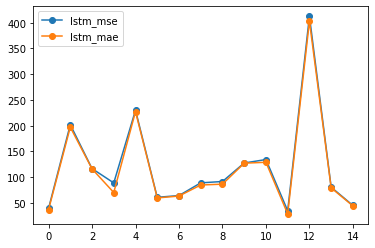

In [29]:
# evaluate model and get scores
predictions , actual_values= predict_model(model, train, test, INPUT_DURATION_MINS)
mse_score, mse_scores, mae_score, mae_scores = evaluate_forecasts(np.array(actual_values), np.array(predictions))
# summarize scores
summarize_scores('lstm', mse_score, mse_scores)
# plot scores
plt.plot(mse_scores, marker='o', label='lstm_mse')
plt.plot(mae_scores, marker='o', label='lstm_mae')
plt.legend()
plt.show()

In [30]:
pd.DataFrame([dataset[1,60:75,-1], predictions[0]], columns=PRED_COLS, index=["Actual", "Predicted"])

,t+1,t+2,t+3,t+4,t+5,t+6,t+7,t+8,t+9,t+10,t+11,t+12,t+13,t+14,t+15
Actual,43.000000,43.000000,44.000000,44.00000,44.000000,44.000000,44.000000,45.000000,44.0000,44.0000,43.000000,44.000000,45.000000,44.000000,43.000000
Predicted,63.708767,84.907867,128.850418,-130.24115,174.812088,117.615639,-49.774784,55.250893,52.9692,-71.8395,64.076622,50.056839,-95.951195,-7.201775,-1.898401
